# AlloLib
This notebook was compiled by Enrico Guarnera and further information can be requested upon emailing at enricog@bii.a-star.edu.sg. AlloLib allows to perform protein binding/mutation perturbations aimed at studing their allosteric effect according to the Structure Based Statistical Mechanical Model of Allostery (SBSMMA). The SBSMMA is referred to the publications:

- Guarnera and Berezovsky, Structure-Based Statistical Mechanical Model Accounts for the Causality and Energetics of Allosteric Communication. PLoS Comput Biol 12, e1004678 (2016), https://doi.org/10.1371/journal.pcbi.1004678
- Guarnera and Berezovsky, Toward Comprehensive Allosteric Control over Protein Activity, Structure (2019), https://doi.org/10.1016/j.str.2019.01.014

The SBSMMA has been also implemented in the AlloSigma server, which is a platform for the analysis of allosteric effects in proteins (https://allosigma.bii.a-star.edu.sg). See for this

- Guarnera , Tan, Zheng, and Berezovsky, AlloSigMA: allosteric signaling and mutation analysis server. Bioinformatics 33, 3996–3998 (2017). https://doi.org/10.1093/bioinformatics/btx430

The SBSMMA was also used to costruct the database AlloMAPS (http://allomaps.bii.a-star.edu.sg/), which provides data on the energetics of communication in proteins with well-documented allosteric regulation, allosteric signalling in PDBselect chains, and allosteric effects of mutations.
- Tan, Tee, Guarnera, Booth, and Berezovsky, AlloMAPS: allosteric mutation analysis and polymorphism of signaling database. Nucleic Acids Res 57, 433 (2018)

AlloLib makes exstensive use of MMTK packages (http://dirac.cnrs-orleans.fr/MMTK.html), which works only with numpy up to version 1.8.2, it is therefore recommended to set up an anaconda virtual enviroment with MMTK installed (see for instance https://anaconda.org/ngraymon/mmtk) along with other packages compatible with version 1.8.2.

Check below the output of the "pip list" command with the versions of some of the packages installed in the enviroment where this notebook was compiled.

idisplay                           0.1.2      
ipykernel                          4.8.2      
ipython                            5.8.0      
ipython-genutils                   0.2.0      
ipywidgets                         7.4.2      
Jinja2                             2.10       
jsonschema                         2.6.0      
jupyter                            1.0.0      
jupyter-client                     5.2.4      
jupyter-console                    5.2.0      
jupyter-core                       4.4.0      
jupyterlab                         0.33.12    
jupyterlab-launcher                0.11.2     
kiwisolver                         1.0.1      
MarkupSafe                         1.1.0      
matplotlib                         1.4.3      
MMTK                               2.7.9      
nbconvert                          5.4.0      
nbformat                           4.4.0      
nodejs                             0.1.1      
nose                               1.3.7      
notebook                           5.7.4      
npm                                0.1.1      
numpy                              1.8.2      
pandas                             0.18.0     
pip                                18.1       
py3Dmol                            0.8.0      
ScientificPython                   2.8.1      
scikit-learn                       0.20.0     
scipy                              0.16.1     
seaborn                            0.7.1      
widgetsnbextension                 3.4.2      

***

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'


from pylab import *
import py3Dmol
import pandas as pd
import os
import fnmatch
import seaborn as sns
sns.set_style("darkgrid")


## Main functions

In [2]:
##############################################################################
# MMTK imports etc.
##############################################################################

from MMTK import *
from MMTK.Proteins import Protein
from MMTK.PDB import PDBConfiguration

from MMTK.PDBMoleculeFactory import *
from MMTK.ForceFields import CalphaForceField, DeformationForceField
from MMTK.FourierBasis import FourierBasis, estimateCutoff
from MMTK.NormalModes import VibrationalModes, EnergeticModes
from MMTK.ForceFields.ForceField import CompoundForceField
from MMTK.ForceFields.Restraints import HarmonicDistanceRestraint
from MMTK.Subspace import RigidMotionSubspace
from MMTK.Visualization import view, viewMode, viewTrajectory

from MMTK.Random import gaussian
from MMTK.Trajectory import Trajectory, SnapshotGenerator, TrajectoryOutput

import itertools as it

#################################################################################################
#Load PDB initialize universe, compute cut-off and biasis
#################################################################################################
def get_universe(pdb_file):

    universe = InfiniteUniverse(CalphaForceField(2.5))
    configurationAll = PDBConfiguration(pdb_file)
    chainsAll = configurationAll.createPeptideChains(model = 'calpha')
    chains=[]
    for i in chainsAll:
        if len(i) > 2:
            chains.append(i)
    universe.protein = Protein(chains)
    X0 = universe.copyConfiguration()
    
    print "Number of chains:", len(chains)
    print "Chain names:", chains
    return X0, chains, universe


#################################################################################################
# normal modes calculation with internal flag for Fourier approx
#################################################################################################
def NMA(universe):
    nbasis = max(200, universe.numberOfAtoms()/10)
    cutoffFOURIER, nbasis = estimateCutoff(universe, nbasis)
    # cutoffFOURIER=None

    if cutoffFOURIER is None:
#         print 'Normal Modes with >>NO<< FOURIER approx'
        # Do full normal mode calculation
        modes = VibrationalModes(universe,None)
    else:
#         print 'Normal Modes >>WITH<< FOURIER approx'
        # Do subspace mode calculation with Fourier basis  
        subspace = FourierBasis(universe, cutoffFOURIER)
        modes = VibrationalModes(universe, None, subspace)

#     print '#eigenvectors: %d #residues: %d' % (len(modes),universe.numberOfAtoms())
    return modes


#################################################################################################
# compute ligand binding perturbation as additional harmonic site restraning in protein system
#################################################################################################
def HarmRestraintSite(universe,site2restraint, site_sel):
    terms=[];
    for ligand in site2restraint:
        for site in site2restraint[ligand]:
            if site in site_sel:            
                site_atoms = site2restraint[ligand][site]
                for a1, a2 in it.combinations(site_atoms,2):
                    d = universe.distance(a1, a2)
                    if d<2.5:
                        if d < 0.4:
                            k = 100*(430000.*d-119500.)
                        else:
                            d3 = d*d*d
                            d6 = d3*d3
                            k = 100*128./d6
                        terms.append(HarmonicDistanceRestraint(a1, a2, d, k))

    return CompoundForceField(*terms);

    
#################################################################################################
# compute mutation perturbations on list of residue positions
#################################################################################################
def PointMutationFF(universe,atom2mutate,alpha):
    terms = []
    for a1, a2 in it.combinations(universe.atomIterator(), 2):
        if a1 not in atom2mutate:
#             pass
            d = universe.distance(a1, a2)
            if d < 2.5:
                if d < 0.4:
                    k = (430000.*d-119500.);
                else:
                    d3 = d*d*d
                    d6 = d3*d3
                    k = 64./d6
                terms.append(HarmonicDistanceRestraint(a1, a2, d, k))
        else:
            d = universe.distance(a1, a2)
            if d < 2.5:
                if d < 0.4:
                    k = (430000.*d-119500.)*alpha;
                else:
                    d3 = d*d*d
                    d6 = d3*d3
                    k = 64.*alpha/d6
                terms.append(HarmonicDistanceRestraint(a1, a2, d, k))
    return CompoundForceField(*terms)



#################################################################################################
# compute atom objects for binding sites 
#################################################################################################
def get_DBsite_atom(DBsite, universe):

    #convert the residues of the sites into atom objects
    atoDict={atom.fullName().split('.')[1]+'.'+atom.fullName().split('.')[2][3:]: atom for atom in universe.atomList()}

    DBsite_atom={ligand: {site: [atoDict[ato] for ato in DBsite[ligand][site]] for site in DBsite[ligand].keys()} for ligand in DBsite.keys()}
        
    return DBsite_atom


#################################################################################################
# get force field for site and mutation
#################################################################################################
def get_FF_SITE_MUT(DBsite_atom, ligand_sel, site_sel, alpha, res2mutate, universe):
    #site retraining
    site2restraint=dict((k,DBsite_atom[k]) for k in ligand_sel)
    siteFF = HarmRestraintSite(universe, site2restraint,site_sel)
    
    # from mutation to atom list
    atoDict={atom.fullName().split('.')[1]+'.'+atom.fullName().split('.')[2][3:]: atom for atom in universe.atomList()}
    atom2mutate=[atoDict[ato] for ato in res2mutate]

    FFMUT = PointMutationFF(universe, atom2mutate, alpha)
    
    #overall effect site + mutations
    force_field =  FFMUT + siteFF
    
    return force_field


#################################################################################################
# get force field for mutation
#################################################################################################
def get_FF_MUT(alpha, res2mutate, universe):
    # from mutation to atom list
    atoDict={atom.fullName().split('.')[1]+'.'+atom.fullName().split('.')[2][3:]: atom for atom in universe.atomList()}
    atom2mutate=[atoDict[ato] for ato in res2mutate]
    
    HarmonicRestraintsFFMUT = PointMutationFF(universe, atom2mutate, alpha)
    force_field =  HarmonicRestraintsFFMUT
    
    return force_field

#################################################################################################
# get force field for restraing of a binding site
#################################################################################################
def get_FF_SITE(DBsite_atom, ligand_sel, site_sel, universe):
    site2restraint=dict((k,DBsite_atom[k]) for k in ligand_sel)
    HarmonicRestraintsFF = HarmRestraintSite(universe, site2restraint,site_sel)
    force_field = CalphaForceField() + HarmonicRestraintsFF
    
    return force_field

#################################################################################################
# Calculate two Allosteric Signaling Maps for UP and DOWN mutations respectively
# It returns two 2D-arrays ASM_UP, ASM_DOWN
# ASM[i] is the per-residue deltag profile as a result of mutation in atom i 
#################################################################################################
def get_ASM(universe):
    
    atom_list_ordered=[ato for c in range(len(chains)) for ato in chains[c].atomList()]
    res2mutate=[ato.fullName().split('.')[1]+'.'+ato.fullName().split('.')[2][3:] for ato in atom_list_ordered]

    ASM_UP=zeros((len(universe.atomList()), len(universe.atomList())))
    ASM_DOWN=zeros((len(universe.atomList()), len(universe.atomList())))
    DgMutation={}

    ind=0
    for residue in res2mutate:
        #UP
        universe.setForceField(get_FF_MUT(100,[residue,],universe))
        modes2UP=NMA(universe)
        deltaGatom_UP=AlloPotFree(universe,X0,modes0,modes2UP)
        #DOWN
        universe.setForceField(CalphaForceField())
        universe.setForceField(get_FF_MUT(0,[residue,],universe))
        modes2DOWN=NMA(universe)
        deltaGatom_DOWN=AlloPotFree(universe,X0,modes0,modes2DOWN)
        print '>>>>>>UP/DOWN MUTATIONS done >>>>>> ', residue 
        # store response row 
        ASM_UP[ind]=array([deltaGatom_UP[ato] for ato in atom_list_ordered])
        ASM_DOWN[ind]=array([deltaGatom_DOWN[ato] for ato in atom_list_ordered])

        ind+=1
    return ASM_UP, ASM_DOWN

#################################################################################################
# get allosteric modulation from ASM 
#################################################################################################
def get_modulation(ASM):
    for i in range(shape(ASM)[0]):
        ASM[i]=ASM[i]-np.mean(ASM[i])
    return ASM

#################################################################################################
# allosteric free energy difference from residue first neighbours Rc = 11A
#################################################################################################
def AlloPotFree(universe,conf,modes0,modes2):
    kT=0.6
    mmode=16
    AlloPot_0={i: zeros(mmode) for i in universe.atomIterator()}
    AlloPot_2={i: zeros(mmode) for i in universe.atomIterator()}

    for a1, a2 in it.combinations(universe.atomIterator(),2):
        dX = (conf[a1]-conf[a2])
        d0 = norm(dX)
        if d0<1.1:
            for m in range(mmode):
                AlloPot_0[a1][m]+=norm(modes0.rawMode(m)[a1]-modes0.rawMode(m)[a2])**2
                AlloPot_0[a2][m]+=norm(modes0.rawMode(m)[a1]-modes0.rawMode(m)[a2])**2
                AlloPot_2[a1][m]+=norm(modes2.rawMode(m)[a1]-modes2.rawMode(m)[a2])**2
                AlloPot_2[a2][m]+=norm(modes2.rawMode(m)[a1]-modes2.rawMode(m)[a2])**2
                
    deltaGatom={atom:-kT*sum(log(array(AlloPot_0[atom])/array(AlloPot_2[atom])))\
                for atom in universe.atomIterator()}
    return deltaGatom

#################################################################################################
# write allosteric free energy in pdb B-factor column
#################################################################################################
def bfactor(pdb_structure, values):
    result = ""
    for line in pdb_structure.split("\n"):
        line = line.ljust(80) # fill the line with spaces up to 80 characters
        if line.startswith("ATOM"):
            # DEBUG result += "%d\n" % (len(line))
            pdb_atomi = line[4:12].strip()
            pdb_chain = line[21:22].strip()
            pdb_resi = line[22:26].strip()
            value = 0.0
            if (pdb_chain, pdb_resi) in values:
                value = values[(pdb_chain, pdb_resi)]
            result += line[:60] + (" %3.2f" % (value)).ljust(6) + line[67:] + "\n"
        elif line.startswith("HETATM"):
            result += line[:60] + " 0.00".ljust(6) + line[67:] + "\n"
        else:
            result += line + "\n"
    return result

def get_bfactor_pdb(deltaGatom,pdbname,universe):
    deltaGatom_structure={}
    for atom in universe.atomList():
        tmp=atom.fullName().split('.')
        deltaGatom_structure[tmp[1], tmp[2][3:]]=deltaGatom[atom]

    pdb_infile = open('%s'%pdbname,'r')
    pdb = pdb_infile.read()
    pdb_infile.close()

    #deltaG in pdb
    pdb_out=bfactor(pdb,deltaGatom_structure)

#     pdb_outfile=open('./PDBs/%s_dG_%s.pdb'% (pdbname,''.join(ligand_sel)),'w')
    pdb_outfile=open(pdbname.split('.')[0]+'_deltag.pdb','w')
    pdb_outfile.write(pdb_out)
    pdb_outfile.close()

#################################################################################################
# AlloRun: main function to perform calculations aimed to obtain per-residue allosteric free  
# energy differences upon binding/mutation perturbations
#################################################################################################  
def AlloRun(DBsite_atom, ligand_sel, site_sel, res2mutate, SITE, MUT, UP, DOWN, universe):

    # normal modes in the unperturbed protein state 
    modes0=NMA(universe)

    if SITE and MUT:
        if UP and DOWN:
            #up mutation
            universe.setForceField(get_FF_SITE_MUT(DBsite_atom, ligand_sel, site_sel, 100, res2mutate, universe))
            modes2UP=NMA(universe)
            deltaGatom_UP=AlloPotFree(universe,X0,modes0,modes2UP)
            #down mutation
            universe.setForceField(get_FF_SITE_MUT(DBsite_atom, ligand_sel, site_sel, 0.001, res2mutate, universe))
            modes2DOWN=NMA(universe)
            deltaGatom_DOWN=AlloPotFree(universe,X0,modes0,modes2DOWN)
            #UP-DOWN
            deltaGatom={ato: deltaGatom_UP[ato]-deltaGatom_DOWN[ato] for ato in universe.atomList() }
            deltaGlist=array([deltaGatom[ato] for ato in universe.atomList()])        
        elif UP:
            universe.setForceField(get_FF_SITE_MUT(DBsite_atom, ligand_sel, site_sel, 100, res2mutate, universe))
            modes2UP=NMA(universe)
            deltaGatom_UP=AlloPotFree(universe,X0,modes0,modes2UP)
            deltaGatom={ato: deltaGatom_UP[ato] for ato in universe.atomList() }
            deltaGlist=array([deltaGatom[ato] for ato in universe.atomList()])
        elif DOWN:
            universe.setForceField(get_FF_SITE_MUT(DBsite_atom, ligand_sel, site_sel, 0.001, res2mutate, universe))
            modes2DOWN=NMA(universe)
            deltaGatom_DOWN=AlloPotFree(universe,X0,modes0,modes2DOWN)
            deltaGatom={ato: deltaGatom_DOWN[ato] for ato in universe.atomList() }
            deltaGlist=array([deltaGatom[ato] for ato in universe.atomList()])

    elif SITE:
        universe.setForceField(get_FF_SITE(DBsite_atom, ligand_sel, site_sel,universe))
        # normal modes perturbed system
        modes2=NMA(universe)
        # calculate the allosteric deltaG per residue
        deltaGatom=AlloPotFree(universe,X0,modes0,modes2)
        deltaGlist=array([deltaGatom[ato] for ato in universe.atomList()])

    elif MUT:
        if UP and DOWN:
            #UP
            universe.setForceField(get_FF_MUT(100,res2mutate,universe))
            modes2UP=NMA(universe)
            deltaGatom_UP=AlloPotFree(universe,X0,modes0,modes2UP)
            #DOWN
            universe.setForceField(CalphaForceField())
            universe.setForceField(get_FF_MUT(0.001,res2mutate,universe))
            modes2DOWN=NMA(universe)
            deltaGatom_DOWN=AlloPotFree(universe,X0,modes0,modes2DOWN)
            #UP-DOWN
            deltaGatom={ato: deltaGatom_UP[ato]-deltaGatom_DOWN[ato] for ato in universe.atomList() }
            deltaGlist=array([deltaGatom[ato] for ato in universe.atomList()])        
        elif UP:
            universe.setForceField(get_FF_MUT(100,res2mutate,universe))
            modes2UP=NMA(universe)
            deltaGatom_UP=AlloPotFree(universe,X0,modes0,modes2UP)
            deltaGatom={ato: deltaGatom_UP[ato] for ato in universe.atomList() }
            deltaGlist=array([deltaGatom[ato] for ato in universe.atomList()])
        elif DOWN:
            universe.setForceField(get_FF_MUT(0.001,res2mutate,universe))
            modes2DOWN=NMA(universe)
            deltaGatom_DOWN=AlloPotFree(universe,X0,modes0,modes2DOWN)
            deltaGatom={ato: deltaGatom_DOWN[ato] for ato in universe.atomList() }
            deltaGlist=array([deltaGatom[ato] for ato in universe.atomList()])
    return deltaGatom


#################################################################################################
# Get the results in forms free energy profiles and pandas tables
#################################################################################################
def get_RESULTS(DBsite_atom,deltaGatom, SITE, ligand_sel, MUT, UP, DOWN, res2mutate, universe):
    #list of chains
    chains=universe.protein
    
    sns.set_style("darkgrid")
    markers = ('ko', 'k<', 'k*', 'kD', '>', 'h', 'H', 'D', 'd')
    figsize=(10,3*len(chains))
    if MUT and SITE:
        DgChain={}
        #atoms per ligand and indexes per ligand
        DgSiteAtom={chain: {ligand: [atom  for site in DBsite_atom[ligand] for atom in DBsite_atom[ligand][site] if atom in chain.atomList()] for ligand in  DBsite_atom} for chain in chains}
        DgSiteAtomIndex={chain: {ligand: [int(atom.fullName().split('.')[2][3:]) for atom in DgSiteAtom[chain][ligand]] for ligand in DgSiteAtom[chain]} for chain in chains} 

        n=1
        figure(figsize=figsize)
        for chain in chains:
            DgChain[chain]={}
            DgChain[chain][0]=array([int(ato.fullName().split('.')[2][3:]) for ato in chain.atomList()])
            DgChain[chain][1]=array([deltaGatom[ato] for ato in chain.atomList()])
            subplot(len(chains),1,n)
            plt.plot(DgChain[chain][0],DgChain[chain][1],'-',linewidth=1,label=str(chain).split('.')[0][7:13]+str(chain).split('.')[1],color='black',alpha=0.5)
            plt.plot(DgChain[chain][0],zeros_like(DgChain[chain][1]),'r--',linewidth=2)
            fill_between(DgChain[chain][0],0,DgChain[chain][1],color='gray',alpha=0.5,interpolate=True)
            ylim([floor(min(deltaGatom.values())),ceil(max(deltaGatom.values()))])
            #sites
            ss=0
            for ligand in DgSiteAtomIndex[chain]:
                if ligand not in ligand_sel:
                    plt.plot(DgSiteAtomIndex[chain][ligand],[deltaGatom[atom] for atom in DgSiteAtom[chain][ligand]],markers[ss],markersize=10,label=ligand,alpha=0.6,markerfacecolor='None',markeredgewidth=1)
                if ligand in ligand_sel:
                    plt.plot(DgSiteAtomIndex[chain][ligand],[deltaGatom[atom] for atom in DgSiteAtom[chain][ligand]],markers[ss],markersize=10,label=ligand,alpha=0.6,color='red')                
                ss+=1
            #mutations
            ss=0
            for res in res2mutate:
                if res.split('.')[0]==chain.name:
                    plt.plot([int(res.split('.')[1]),],[deltaGatom[atom] for atom in chain.atomList() if int(atom.fullName().split('.')[2][3:])==int(res.split('.')[1])],markers[ss],markersize=10, color='red',label=res,alpha=0.6)
                ss+=1        
            plt.ylabel('[kcal/mol]', fontsize=22)
            plt.xlim([DgChain[chain][0][0], DgChain[chain][0][-1]])
            plt.legend(bbox_to_anchor=(1.3, 0.5), loc=7, fontsize=12)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            n+=1
        plt.xlabel('Residue', fontsize=28) 

    elif MUT:
        DgChain={}
        #atoms per ligand and indexes per ligand
        DgSiteAtom={chain: {ligand: [atom  for site in DBsite_atom[ligand] for atom in DBsite_atom[ligand][site] if atom in chain.atomList()] for ligand in  DBsite_atom} for chain in chains}
        DgSiteAtomIndex={chain: {ligand: [int(atom.fullName().split('.')[2][3:]) for atom in DgSiteAtom[chain][ligand]] for ligand in DgSiteAtom[chain]} for chain in chains} 

        n=1
        figure(figsize=figsize)
        for chain in chains:
            DgChain[chain]={}
            DgChain[chain][0]=array([int(ato.fullName().split('.')[2][3:]) for ato in chain.atomList()])
            DgChain[chain][1]=array(uniform_filter([deltaGatom[ato] for ato in chain.atomList()],1))
            subplot(len(chains),1,n)
            plt.plot(DgChain[chain][0],DgChain[chain][1],'k-',linewidth=1,label=str(chain).split('.')[0][7:13]+str(chain).split('.')[1],alpha=0.5)
            plt.plot(DgChain[chain][0],zeros_like(DgChain[chain][1]),'r--',linewidth=2)
            fill_between(DgChain[chain][0],0,DgChain[chain][1],color='gray',alpha=0.5,interpolate=True)
            if UP: ylim([floor(min(deltaGatom.values())),ceil(max(deltaGatom.values()))])
            elif DOWN: ylim([-0.2,0.2])
            ss=0
            for ligand in DgSiteAtomIndex[chain]:
                if ligand not in ligand_sel:
                    plt.plot(DgSiteAtomIndex[chain][ligand],[deltaGatom[atom] for atom in DgSiteAtom[chain][ligand]],markers[ss],markersize=10,label=ligand,alpha=0.6,markerfacecolor='None',markeredgewidth=1)
                if ligand in ligand_sel:
                    plt.plot(DgSiteAtomIndex[chain][ligand],[deltaGatom[atom] for atom in DgSiteAtom[chain][ligand]],markers[ss],markersize=10,label=ligand,alpha=0.6,color='red')
                ss+=1        
            ss=0
            for res in res2mutate:
                if res.split('.')[0]==chain.name:
                    plt.plot([int(res.split('.')[1]),],[deltaGatom[atom] for atom in chain.atomList() if int(atom.fullName().split('.')[2][3:])==int(res.split('.')[1])],markers[ss],markersize=10, color='red',label=res,alpha=0.6)
                ss+=1
            plt.ylabel('[kcal/mol]', fontsize=22)
            plt.xlim([DgChain[chain][0][0], DgChain[chain][0][-1]])
            plt.legend(bbox_to_anchor=(1.3, 0.5), loc=7, fontsize=14)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)

            n+=1
        plt.xlabel('Residue', fontsize=28)


    elif SITE:
        DgChain={}
        #atoms per ligand and indexes per ligand
        DgSiteAtom={chain: {ligand: [atom  for site in DBsite_atom[ligand] for atom in DBsite_atom[ligand][site] if atom in chain.atomList()] for ligand in  DBsite_atom} for chain in chains}
        DgSiteAtomIndex={chain: {ligand: [int(atom.fullName().split('.')[2][3:]) for atom in DgSiteAtom[chain][ligand]] for ligand in DgSiteAtom[chain]} for chain in chains} 

        n=1
        figure(figsize=figsize)
        for chain in chains:
            DgChain[chain]={}
            DgChain[chain][0]=array([int(ato.fullName().split('.')[2][3:]) for ato in chain.atomList()])
            DgChain[chain][1]=array([deltaGatom[ato] for ato in chain.atomList()])
            subplot(len(chains),1,n)
            plt.plot(DgChain[chain][0],DgChain[chain][1],'k-',linewidth=1,label=str(chain).split('.')[0][7:13]+str(chain).split('.')[1],alpha=0.5)
            fill_between(DgChain[chain][0],0,DgChain[chain][1],color='gray',alpha=0.5,interpolate=True)
            plt.plot(DgChain[chain][0],zeros_like(DgChain[chain][1]),'r--',linewidth=2)
            ylim([floor(min(deltaGatom.values())),ceil(max(deltaGatom.values()))])
            ss=0
            for ligand in DgSiteAtomIndex[chain]:
                if ligand not in ligand_sel:
                    plt.plot(DgSiteAtomIndex[chain][ligand],[deltaGatom[atom] for atom in DgSiteAtom[chain][ligand]],markers[ss],markersize=10,label=ligand,alpha=0.6,markerfacecolor='white',markeredgewidth=1)
                if ligand in ligand_sel:
                    plt.plot(DgSiteAtomIndex[chain][ligand],[deltaGatom[atom] for atom in DgSiteAtom[chain][ligand]],markers[ss],markersize=10,label=ligand,alpha=0.6,color='red')                
                ss+=1
            plt.ylabel('[kcal/mol]', fontsize=22)
            plt.xlim([DgChain[chain][0][0], DgChain[chain][0][-1]])
            plt.legend(bbox_to_anchor=(1.25, 0.5), loc=7, fontsize=18)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            n+=1
        plt.xlabel('Residue', fontsize=28)
    
    DgSite={}
    for ligand in DBsite_atom:
        DgSite[ligand]={site: 0 for site in DBsite_atom[ligand]}
        for site in DBsite_atom[ligand]:
            for atom in DBsite_atom[ligand][site]:
                DgSite[ligand][site]+=deltaGatom[atom]/len(DBsite_atom[ligand][site])

    DhSite={}
    for ligand in DBsite_atom:
        DhSite[ligand]={site: 0 for site in DBsite_atom[ligand]}
        for site in DBsite_atom[ligand]:
            for atom in DBsite_atom[ligand][site]:
                DhSite[ligand][site]+=(deltaGatom[atom]-mean(deltaGatom.values()))/len(DBsite_atom[ligand][site])

    DgType={'$\Delta g$': {}, '$\Delta h$': {}}
    for ligand in DgSite:
        DgType['$\Delta g$'][ligand]=0
        DgType['$\Delta h$'][ligand]=0
        for site in DgSite[ligand]:
            DgType['$\Delta g$'][ligand]+=DgSite[ligand][site]/len(DgSite[ligand].keys())
        DgType['$\Delta g$'][ligand]=DgType['$\Delta g$'][ligand]
        DgType['$\Delta h$'][ligand]=DgType['$\Delta g$'][ligand] - mean(deltaGatom.values())
    DgType['$\Delta g$']['Protein']=mean(deltaGatom.values())
    DgType['$\Delta h$']['Protein']=0

    for chain in DgChain:
        DgType['$\Delta g$'][str(chain).split('.')[0][7:13]+str(chain).split('.')[1]]=mean(DgChain[chain][1])
        DgType['$\Delta h$'][str(chain).split('.')[0][7:13]+str(chain).split('.')[1]]=mean(DgChain[chain][1])-mean(deltaGatom.values())

    DgSite_df=pd.DataFrame.from_dict(DgSite)
    DhSite_df=pd.DataFrame.from_dict(DhSite)
    DgType_df=pd.DataFrame.from_dict(DgType)

    DgSite_df['Type']=['$\Delta g$' for i in range(len(DgSite.keys()))]
    DhSite_df['Type']=['$\Delta h$' for i in range(len(DgSite.keys()))]

    return DgSite_df, DhSite_df, DgType_df

## Binding sites

In the following cell a dictionary (DBsite) of binding sites is defined for the PFK protein and PDZ domain as examples. For each protein name a sub-dictionary of site names is given, followed by a further sub-dictionary of sites given by a list of residues  according to the format 

{site: ('chain-residue', 'chain-residue', ... )}.

Four site names are considered in PFK - F6P, ADPf, ADPa, and PEP - which have four binding sites each, while in PDZ the substrate site SUB is given.

In [3]:
DBpdb={'PFK': '3pfk_ass.pdb', 'PDZ': '1be9.pdb'}

DBsite={}

DBsite['PFK']={'F6P': {1: ('A.162', 'A.243', 'D.127', 'D.169', 'D.170', 'D.171', 'D.222', 'D.249', 'D.252'),\
                      2: ('D.162', 'D.243', 'A.127', 'A.169', 'A.170', 'A.171', 'A.222', 'A.249', 'A.252'),\
                      3: ('G.162', 'G.243', 'J.127', 'J.169', 'J.170', 'J.171', 'J.222', 'J.249', 'J.252'),\
                      4: ('J.162', 'J.243', 'G.127', 'G.169', 'G.170', 'G.171', 'G.222', 'G.249', 'G.252')},\
              'ADPf':{1: ('A.9', 'A.10', 'A.41', 'A.72', 'A.73', 'A.76', 'A.77', 'A.104', 'A.108', 'A.111'),\
                      2: ('D.9', 'D.10', 'D.41', 'D.72', 'D.73', 'D.76', 'D.77', 'D.104', 'D.108', 'D.111'),\
                      3: ('G.9', 'G.10', 'G.41', 'G.72', 'G.73', 'G.76', 'G.77', 'G.104', 'G.108', 'G.111'),\
                      4: ('J.9', 'J.10', 'J.41', 'J.72', 'J.73', 'J.76', 'J.77', 'J.104', 'J.108', 'J.111')},\
              'ADPa':{1: ('A.154', 'A.185', 'A.187', 'A.211', 'A.212', 'A.213', 'A.214', 'A.215', 'D.21', 'D.25', 'D.54', 'D.58', 'D.59'),\
                      2: ('D.154', 'D.185', 'D.187', 'D.211', 'D.212', 'D.213', 'D.214', 'D.215', 'A.21', 'A.25', 'A.54', 'A.58', 'A.59'),\
                      3: ('G.154', 'G.185', 'G.187', 'G.211', 'G.212', 'G.213', 'G.214', 'G.215', 'J.21', 'J.25', 'J.54', 'J.58', 'J.59'),\
                      4: ('J.154', 'J.185', 'J.187', 'J.211', 'J.212', 'J.213', 'J.214', 'J.215', 'G.21', 'G.25', 'G.54', 'G.58', 'G.59')},\
              'PEP': {1: ('A.21', 'A.25', 'A.54', 'A.58', 'A.59', 'D.154', 'D.211', 'D.213', 'D.214'),\
                      2: ('D.21', 'D.25', 'D.54', 'D.58', 'D.59', 'A.154', 'A.211', 'A.213', 'A.214'),\
                      3: ('G.21', 'G.25', 'G.54', 'G.58', 'G.59', 'J.154', 'J.211', 'J.213', 'J.214'),\
                      4: ('J.21', 'J.25', 'J.54', 'J.58', 'J.59', 'G.154', 'G.211', 'G.213', 'G.214')}\
                    }

DBsite['PDZ']={'SUB': {1: ('A.323', 'A.324', 'A.325', 'A.326', 'A.327', 'A.328', 'A.339', 'A.372', 'A.373', 'A.379', 'A.380')}}


## MMTK universe
In this cell the protein name - prot - is selected from previous DB with corresponding pdb name - pdbname. The function get_universe(pdbname) create a MMTK universe from pdb in the current forlder./, store the protein chains and configuration X0.

The DBsite_atom is the  dictionary of binding sites listed as lists of residues in MMTK language.

In [4]:
#chose the protein and visualize the corresponding dictionary of sites as a dataframe
prot='PFK'
display(pd.DataFrame.from_dict(DBsite[prot]))

#pdb structure which must be present in ./
pdbname=DBpdb[prot]

#create universe from pdb, get protein chains and configuration X0
X0, chains, universe= get_universe(pdbname)

# get a dictionary of binding sites listed as lists of residues in MMTK language
DBsite_atom =get_DBsite_atom(DBsite[prot],universe)

ADPa  \
1  (A.154, A.185, A.187, A.211, A.212, A.213, A.2...   
2  (D.154, D.185, D.187, D.211, D.212, D.213, D.2...   
3  (G.154, G.185, G.187, G.211, G.212, G.213, G.2...   
4  (J.154, J.185, J.187, J.211, J.212, J.213, J.2...   

                                                ADPf  \
1  (A.9, A.10, A.41, A.72, A.73, A.76, A.77, A.10...   
2  (D.9, D.10, D.41, D.72, D.73, D.76, D.77, D.10...   
3  (G.9, G.10, G.41, G.72, G.73, G.76, G.77, G.10...   
4  (J.9, J.10, J.41, J.72, J.73, J.76, J.77, J.10...   

                                                 F6P  \
1  (A.162, A.243, D.127, D.169, D.170, D.171, D.2...   
2  (D.162, D.243, A.127, A.169, A.170, A.171, A.2...   
3  (G.162, G.243, J.127, J.169, J.170, J.171, J.2...   
4  (J.162, J.243, G.127, G.169, G.170, G.171, G.2...   

                                                 PEP  
1  (A.21, A.25, A.54, A.58, A.59, D.154, D.211, D...  
2  (D.21, D.25, D.54, D.58, D.59, A.154, A.211, A...  
3  (G.21, G.25, G.54, G.58, G.59, J.154, J.211, J...  
4  (J.21, J.25, J.54, J.58, J.59, G.154, G.211, G...

Number of chains: 4
Chain names: [PeptideChain .A, PeptideChain .D, PeptideChain .G, PeptideChain .J]


# AlloRun

In this cell the perturbation based calculations of the allosteric effects upon libag binding and mutations are performed.
First, a ligand type can be chosen from the availabe ones in DBsite (ligand_sel), as well as the specific sites to be perturbed (site_sel). In the example below, all four ADPa sites are selected. Multiple site types can also be selected.

In residue_sel a list of residues to be perturbed can be given in the format ['chain.residue',...]. 

Two harmonic energy functions are considered, one associated with the unperturbed protein state

$$E^{(0)}=\sum_{\langle i,j \rangle}k_{ij}(d_{ij}-d_{ij}^0)^2 $$

with $d_{ij}$ the distance between Ca atoms between i and j, $d^0_{ij}$ the
corresponding distance in the reference structure, $k_{ij}$ distance-dependent force constant, and the summation running over the pairs of neighbors i,j within a global distance cutoff.

The harmonic energy associated with generic ligand binding in a site $S$ and mutation in residue $m$ perturbation $(P)$ is

$$
E^{(P)}(S, m)=\sum_{\langle i,j \rangle, j\neq m} = k_{ij}(d_{ij}-d_{ij}^0)^2 + \\ \alpha \sum_{i,j\in S}=k_{ij}(d_{ij}-d_{ij}^0)^2 + \\ \theta \sum_{\langle m,j \rangle}=k_{mj}(d_{mj}-d_{mj}^0)^2
$$

where the $\alpha$ term accounts for the ligand binding, modeled as a stiffening perturbation ($\alpha>>1$), while the $\theta$ term describes residue substitutions, which can be either stabilizing (UP, $\theta>>1$) or destabilizing (DOWN, $\theta<<1$).

The allosteric effect is given as a per-residue free energy difference, which is calculated from the ratio of local per-residue partition functions

$$ \Delta g_i=k_B T\ln \frac{z_i^{(0)}}{z_i^{(P)}}$$

In the code below boolean variables are set to combine ligand binding with mutational perturbations. If SITE is set to True the AlloRun function performs pertubation at the selected binding sites. If MUT is set to True mutations are performed at the selected residues, which can be either stabilizing if UP=True and DOWN=False or destabilizing - UP=False and DOWN=True. If both  UP and DOWN are set to True both mutations are performed at the selected residues and the modulation range is obtained as a difference benween the free energies in the UP- and DOWN-mutated protein states.

In the example below, the calculation of the allosteric effect as a result of binding at four ADPa sites and stabilizing UP-mutations at Val54 of the PFK protein is performed.

The result of the AlloRun function is a dictionary of atom keys with associated the corresponding calculated $\Delta g^{(P)}_i$, which is given in [kcal/mol]. 

In [5]:
#################################################################################################
# Binding and mutations
#################################################################################################

#################################################################################################
# set the sites to perturb/bind
#################################################################################################
ligand_sel=['ADPa'] # site types to be perturbed
site_sel=[1,2,3,4]  # sites of the given above type to be perturbed

#################################################################################################
# set the residues to perturb/mutate as a list of 'chain.res' 
#################################################################################################
residue_sel=['A.54', 'D.54', 'G.54', 'J.54']
# residue_sel=['A.154', 'D.154', 'G.154', 'J.154']
# residue_sel=['A.187', 'D.187', 'G.187', 'J.187']
# residue_sel=['A.211', 'D.211', 'G.211', 'J.211']
# residue_sel=['A.213', 'D.213', 'G.213', 'J.213']
# residue_sel=['A.170', 'D.170', 'G.170', 'J.170']

SITE=True  # if True it performs pertubation at the selected binding sites

MUT=True   # if True it performs mutations at the selected residues
UP=True    # if True it performs stabilizing mutations at the selected residues
DOWN=False # if True it performs destabilizing mutations at the selected residues
# NB. if both  UP and DOWN are set to True both mutations are performed at selected 
# residues and the modulation range is obtained as a difference benween free energies
# in the UP- and DOWN-mutated protein states.

# AlloRun, the function to obtain free energy difference upon combined ligand binding/mutation 
# perturbations
Dg_atom=AlloRun(DBsite_atom, ligand_sel, site_sel, residue_sel, SITE, MUT, UP, DOWN, universe)

## Visualize results
The allosteric effect resulating from a perturbation (binding/mutation) is evaluated in terms of allosteric modulation ($\Delta h^{(P)}_{i}=\Delta g^{(P)}_{i}-\langle \Delta g^{(P)}_i \rangle_{chain}$, which distiguishes between allosteric and global effects. The function get_RESULTS is used to viusalize the results in terms of allosteric modulation profiles and dataframes.



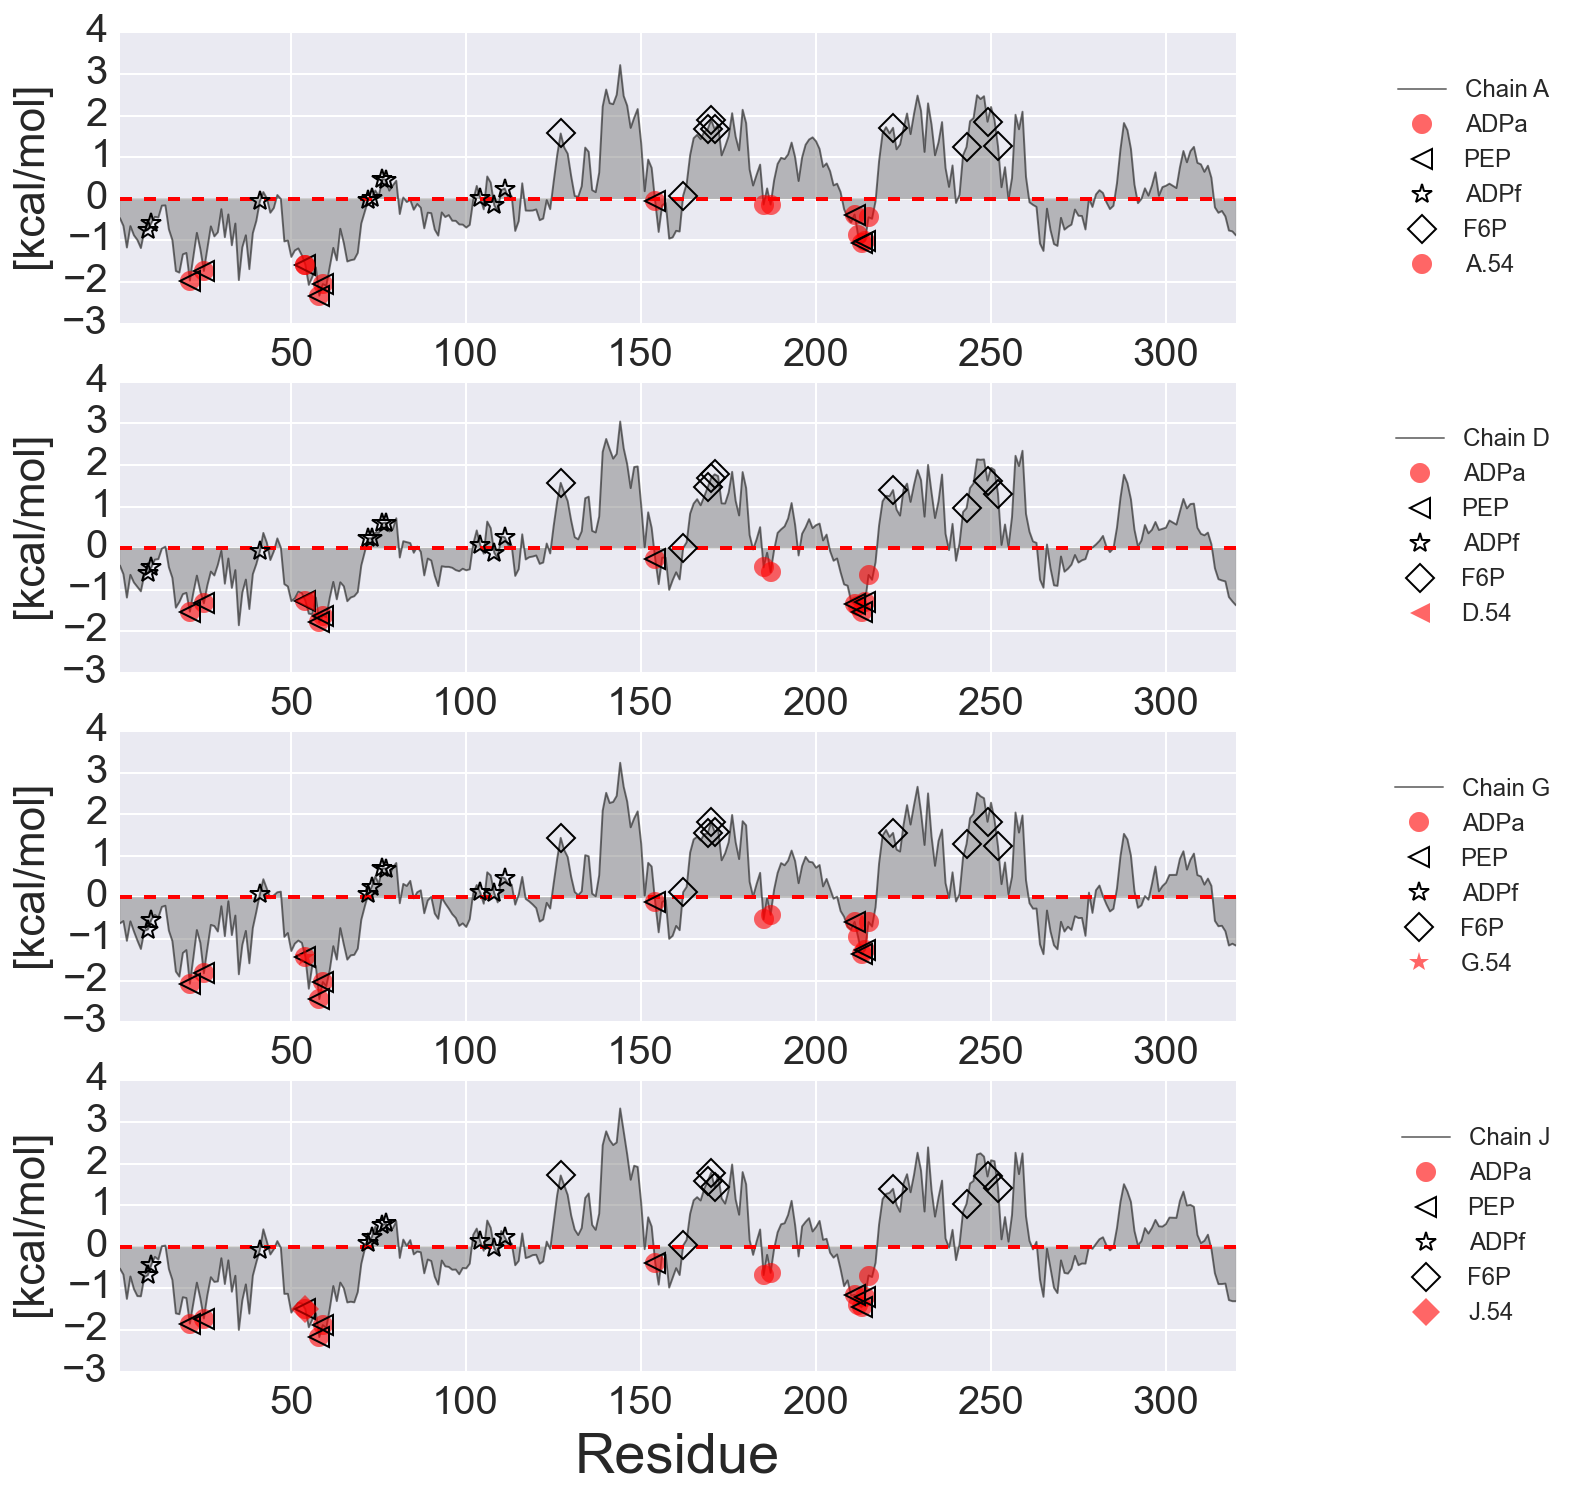

In [6]:
# output of the get_RESULTS function are pandas dataframes and allosteric modulation profiles: 
DgSite_df, DhSite_df, DgType_df = get_RESULTS(DBsite_atom,Dg_atom, SITE, ligand_sel, MUT, UP, DOWN, residue_sel, universe)

## Results dataframe 1
- DgSite_df $\to$ $\Delta g^{(P)}_{site}$ detected in all the sites annotated in DBsite
- DhSite_df $\to$ allosteric modulation $\Delta h^{(P)}_{site}=\Delta g^{(P)}_{site}-\langle \Delta g^{(P)}_i \rangle_{chain}$ detected in all the sites annotated in DBsite

In [7]:
display(DgSite_df)
display(DhSite_df)

ADPa      ADPf       F6P       PEP        Type
1 -0.896587 -0.034280  1.348080 -1.568755  $\Delta g$
2 -1.322800  0.077989  1.399650 -1.116664  $\Delta g$
3 -1.148756  0.120704  1.382181 -1.554281  $\Delta g$
4 -1.336704  0.054844  1.336959 -1.383133  $\Delta g$

ADPa      ADPf       F6P       PEP        Type
1 -1.050804 -0.188496  1.193863 -1.722972  $\Delta h$
2 -1.477017 -0.076227  1.245433 -1.270881  $\Delta h$
3 -1.302972 -0.033513  1.227964 -1.708498  $\Delta h$
4 -1.490921 -0.099372  1.182743 -1.537349  $\Delta h$

## Results dataframe 2
- DgType_df $\to$ $\Delta g^{(P)}_{type}=\langle \Delta g^{(P)}_{type}\rangle_{site}$ and $\Delta h^{(P)}_{type}=\langle \Delta h^{(P)}_{type}\rangle_{site}$ per site type, averaged over the correposnding sites.

In [8]:
display(DgType_df)

$\Delta g$  $\Delta h$
ADPa      -1.176212   -1.330428
ADPf       0.054814   -0.099402
Chain A    0.187427    0.033211
Chain D    0.149105   -0.005112
Chain G    0.158266    0.004050
Chain J    0.122068   -0.032148
F6P        1.366717    1.212501
PEP       -1.405708   -1.559925
Protein    0.154217    0.000000

## Visualize allosteric response via py3Dmol
In the cell below py3Dmol (https://pypi.org/project/py3Dmol/) is used to to visualize the protein structure colored according to the allosteric response.

The function get_bfactor_pdb is used to write a pdb file (./pdbname.deltag.pdb) with the b-fact colum filled with per-residue free energy differences obtained from AlloRun.

In [24]:
#write a pdb with the b-fact column with delta g
get_bfactor_pdb(Dg_atom,pdbname,universe)

# set a cutoff for the color map visualization
cut=2


pdbdata=open(pdbname.split('.')[0]+'_deltag.pdb', 'r').read()
view=py3Dmol.view(width=500, height=500)
view.addModel(pdbdata,'pdb')
view.zoomTo()
view.setBackgroundColor('white')
view.setStyle({'hidden':'True'})

#visualization styles
view.setViewStyle({'style':'outline','color':'black','width':0.05})
# view.addSurface(py3Dmol.SAS,{'opacity':0.9,'colorscheme':{'prop':'b','gradient':'rwb','min':-cut,'max':cut}})
view.setStyle({'cartoon': {'opacity':1,'colorscheme':{'prop':'b','gradient':'rwb','min':-cut,'max':cut},'style':'oval','cartoon':True}})
# view.setStyle({'cartoon': {'opacity':0.8,'color':'white','style':'oval',  'ribbon':True, 'thickness': 1.2,'colorscheme':{'prop':'b','gradient':'rwb','min':-cut,'max':cut}}})


#PFK sites
ADPa={'resi': (154, 185, 187, 211, 212, 213, 214, 215, 21, 25, 54, 58, 59)}
ADPf={'resi': (9, 10, 41, 72, 73, 76, 77, 104, 108, 111)}
F6P={'resi': (162, 243, 127, 169, 170, 171, 222, 249, 252)}
PEP={'resi': (21, 25, 54, 58, 59, 154, 211, 213, 214)}

#to visualize binding sites
view.addSurface(py3Dmol.SAS,{'opacity':0.9,'color':'white'},F6P)
# view.addSurface(py3Dmol.SAS,{'opacity':0.9,'color':'#DF5B5F'},PEP)
# view.addSurface(py3Dmol.SAS,{'opacity':0.9,'color':'#F5D327'},ADPf)

#PDZ site
SUB={'resi': (323, 324, 325, 326, 327, 328, 339, 372, 380)}
# view.addSurface(py3Dmol.SAS,{'opacity':0.5,'color':'#575BE7'},SUB)

view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Figure
Below one can drang and save the figure.

In [28]:
view.png()

# Allosteric Signaling Maps (ASM)

In the following the procedure to obtain and store ASM as a result of complete single point UP/DOWN mutations. 
This calculation can be slow depending on the size of the systems: the rate of single point mutations per hour as a function of the number of residues decreases with number of residues of the protein. See the cell below. In case of PFK the calculation takes about three days of computing time. 

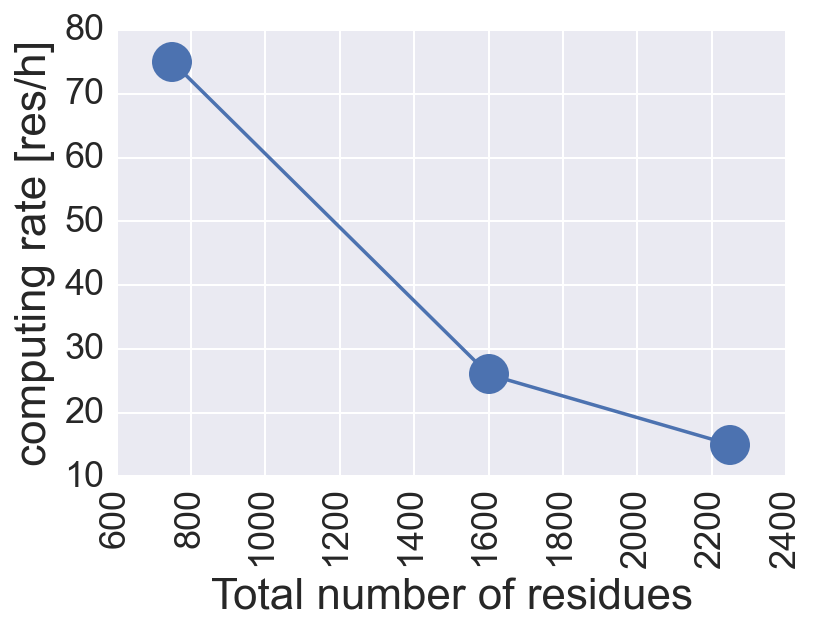

In [25]:
res=[750,1600, 2250]
rate=[75,26,15]

sns.set_style("darkgrid")
plot(res,rate,'o-',markersize=20);
xlabel('Total number of residues',fontsize=22)
ylabel('computing rate [res/h]',fontsize=22)
# yscale('log')
plt.xticks(rotation='90',fontsize=18);
plt.yticks(fontsize=18);

## ASM calculation

The function get_ASM performs a complete scan for UP and DOWN mutations to obtain two separate ASMs. For small protein it can be reasonably fast, such as PDZ. The cell below is the result of the calculations performed for PDZ, if you wish to repeat these you need to load PDZ from the above cells.

In [52]:
# get ASM >>> THIS CAN BE SLOW <<<
ASM_UP, ASM_DOWN = get_ASM(universe)

#################################################################################################   
# output files

#PFK
# ASM_UP.tofile('./3pfk_ASM_UP.mat')
# ASM_DOWN.tofile('./3pfk_ASM_DOWN.mat')

#PDZ
ASM_UP.tofile('./1be9_ASM_UP.mat')
ASM_DOWN.tofile('./1be9_ASM_DOWN.mat')


>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.301
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.302
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.303
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.304
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.305
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.306
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.307
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.308
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.309
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.310
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.311
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.312
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.313
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.314
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.315
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.316
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.317
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.318
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.319
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.320
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.321
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.322
>>>>>>UP/DOWN MUTATIONS done >>>>>>  A.323
>>>>>>UP/DO

# Load ASMs from local files

In [26]:
# PFK ASM for UP/DOWN mutations
ASM_UP=fromfile('./3pfk_ASM_UP.mat','float64')
ASM_DOWN=fromfile('./3pfk_ASM_DOWN.mat','float64')


# PDZ ASM for UP/DOWN mutations
# ASM_UP=fromfile('./1be9_ASM_UP.mat','float64')
# ASM_DOWN=fromfile('./1be9_ASM_DOWN.mat','float64')



ASM_UP.shape   = int(sqrt(len(ASM_UP))), int(sqrt(len(ASM_UP)))
ASM_DOWN.shape = int(sqrt(len(ASM_DOWN))), int(sqrt(len(ASM_DOWN)))


## Visualize ASMs

(0, 1276)

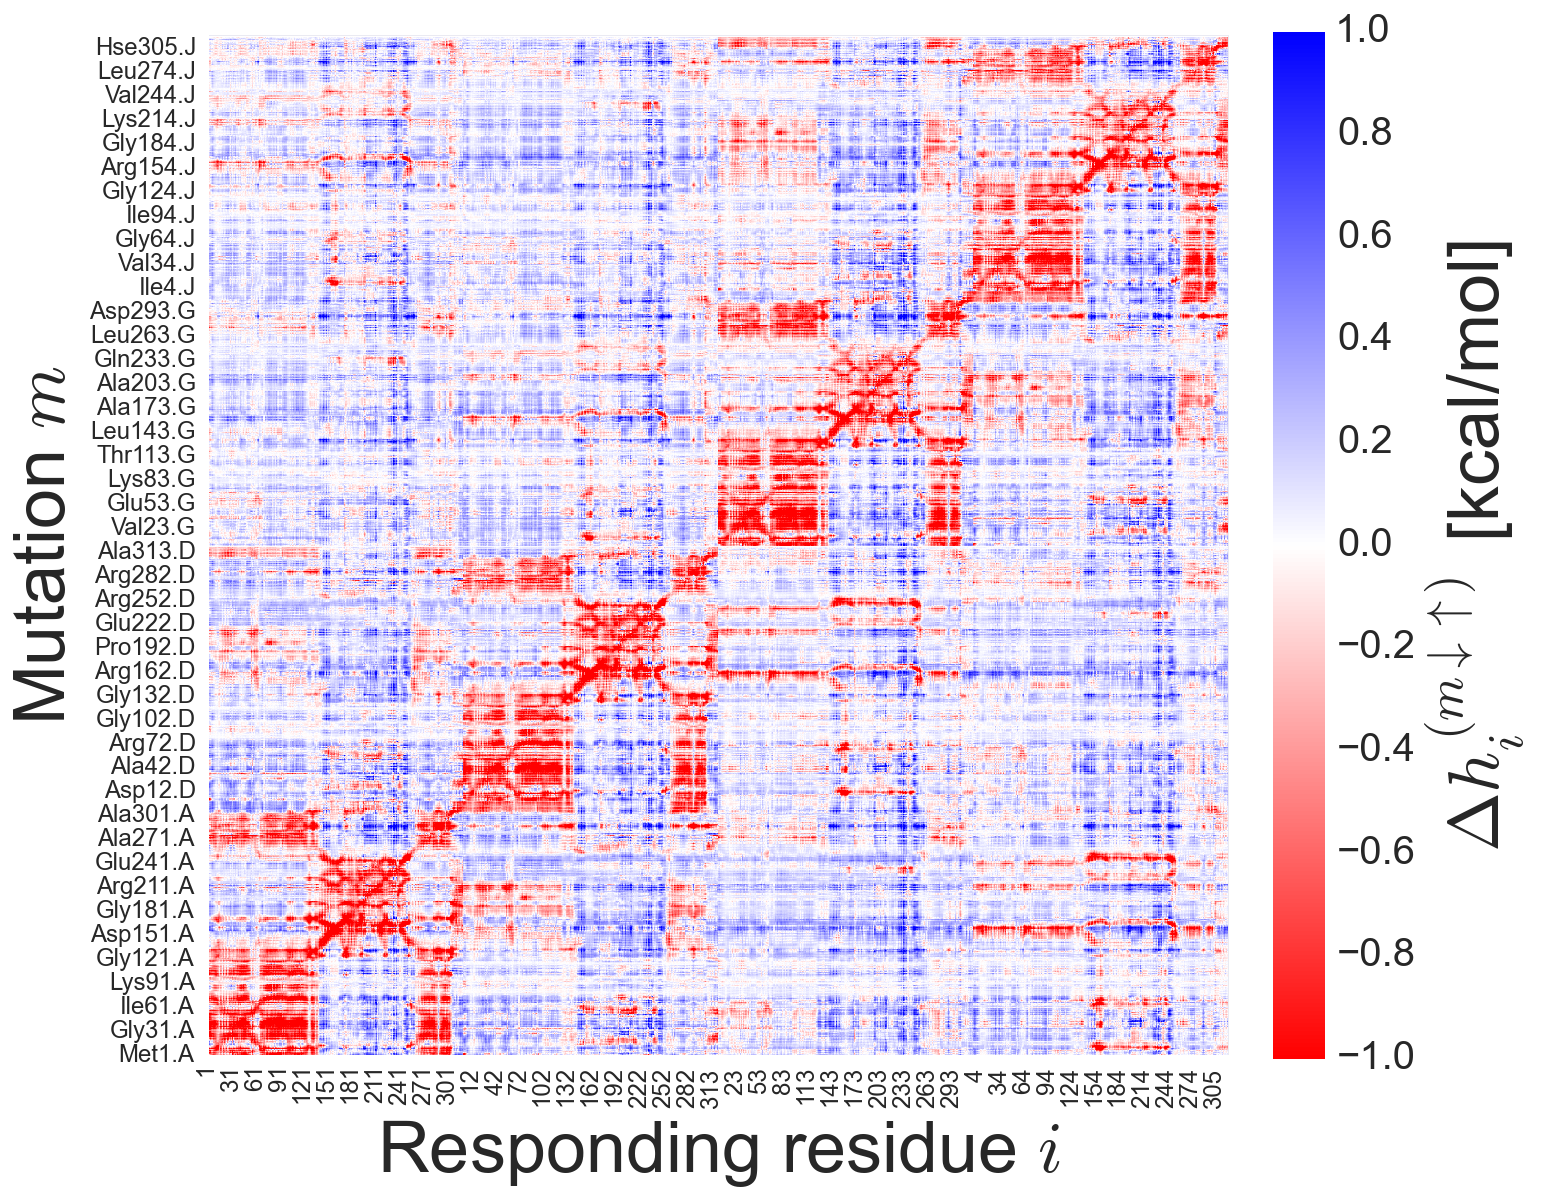

In [27]:
#################################################################################################   
# get residue numbers a nd names for visualization

# ordered list of the protein atoms in MMTK language
atom_list_ordered=[ato for c in range(len(chains)) for ato in chains[c].atomList()]

# ordered list of residue numbers
res_number=array([int(i.fullName().split('.')[2][3:]) for i in atom_list_ordered])

# ordered list of residue names
res_list=array([i.fullName().split('.')[2]+'.'+i.fullName().split('.')[1] for i in atom_list_ordered])

#dictionary of the residues associated with the ligands
ligand_atom_list={lig: [atom_list_ordered.index(i) for site in DBsite_atom[lig] for i in DBsite_atom[lig][site]] for lig in DBsite_atom}


# get modulation range 
ASM=get_modulation(ASM_UP-ASM_DOWN)


sns.set_style("dark")
cut=1

figure(figsize=(10,10))
imshow(ASM,cmap='bwr_r',origin='lower',interpolation='none',vmin=-cut,vmax=cut)

cbar=colorbar(fraction=0.046, pad=0.04)
gca().set_aspect('equal')
xlabel('Responding residue $i$', fontsize=36)
ylabel('Mutation $m$', fontsize=36)
cbar.set_label('$\Delta h_{i}^{(m\downarrow\uparrow)} $ [kcal/mol]', fontsize=36)
cbar.ax.tick_params(labelsize=20)
skip=30
gca().set_yticks(arange(0,len(res_number),skip));
gca().set_yticklabels(res_list[arange(0,len(res_number),skip)]);
gca().set_xticks(arange(0,len(res_number),skip));
gca().set_xticklabels(res_number[arange(0,len(res_number),skip)]);
xticks(rotation='90',fontsize=12);
yticks(fontsize=12);
xlim([0,shape(ASM_UP)[1]])
ylim([0,shape(ASM_UP)[0]])


## Allosteric modulation of a site type as a function of single point mutations

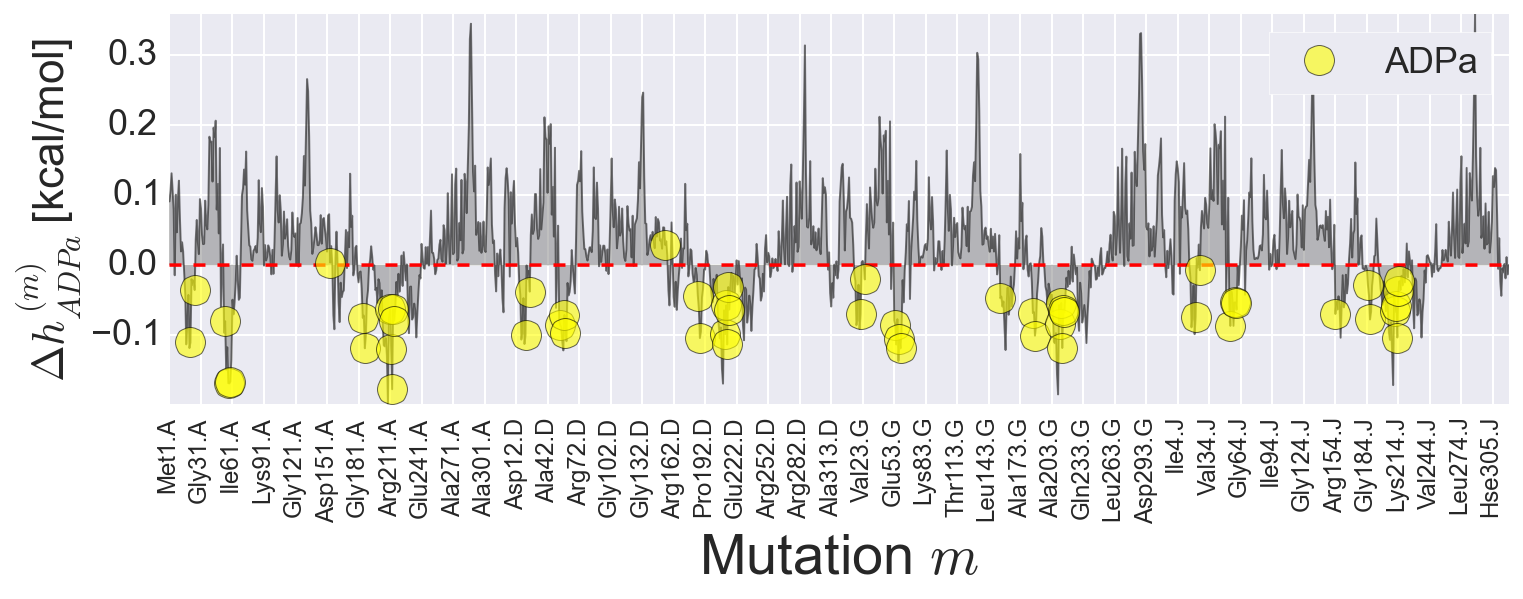

In [12]:
figure(figsize=(12,3.5))

ligo='ADPa'

MAT=get_modulation(ASM_UP)

S0=MAT[:,ligand_atom_list[ligo]]

S1=zeros(shape(MAT)[0])

for i in range(shape(S0)[1]):
    S1+=S0[:,i]/shape(S0)[1]

sns.set_style("darkgrid")

fill_between(range(len(S1)),0,S1,color='gray',alpha=0.5,interpolate=False)
plot(S1,linewidth=1,color='black',alpha=0.5)
plot(zeros(len(res_number)), 'r--')
ligo1=ligo
plot(ligand_atom_list[ligo1],S1[ligand_atom_list[ligo1]],'yo',label=ligo1,markersize=15,alpha=0.6,markerfacecolor='yellow',markeredgewidth=0.5,markeredgecolor='k')

gca().set_xticks(arange(0,len(res_number),skip));
gca().set_xticklabels(res_list[arange(0,len(res_number),skip)]);
xticks(rotation='90',fontsize=12);
yticks(fontsize=18);
# xlim([arange(0,len(res_number))[10],arange(0,len(res_number))[-28]])
xlim([arange(0,len(res_number))[0],arange(0,len(res_number))[-1]])
ylim([(min(S1)),(max(S1))])
# ylim([-2,2])

ylabel('$\Delta h_{'+ligo+'}^{(m)}$ [kcal/mol]', fontsize=22)
xlabel('Mutation $m$', fontsize=28)
legend(frameon=True,loc=1,fontsize=18)
